# Phase 3 - Modeling

**Note 1: the following starting code only generates a single random train/test split when default_seed is used. You need to modify the code to generate 100 independent train/test splits with different seeds and report the average results on those independent splits along with standard deviation.**

**Note 2: You are completely free to use your own implementation.**

## This is the Jupyter Notebook that contains all code necessary to run the Regressors and Sensitivity of Portfolio Size

In [1]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.dummy import DummyClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores

def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [3]:
default_seed = 1
output_file = "output_sample"

In [4]:
# Create a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [5]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "dataclean_data.pickle", "rb" ) )

In [6]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise

loan_stats= data['loan_status']
outcome_values = []
for value in loan_stats:
    if value == 'Charged Off' or value == 'Default':
        outcome_values.append(True)
    else:
        outcome_values.append(False)
data["outcome"] = outcome_values

mask = np.array(loan_stats == 'Charged Off')
mask_2 = np.array(loan_stats == 'Default')

outcome_array = np.array(outcome_values)
mask = np.array(outcome_array == True)

In [7]:
# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [8]:
# Randomly assign each row to a training and test set. 
#We do this now because we will be fitting a variety of models on various time periods,
#and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance
#and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing

train_array = np.array([True, False])
train = np.random.choice(train_array, data.shape[0], p=[0.7, 0.3])
data['train'] = train

In [9]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

## Prepare functions to fit and evaluate models

In [10]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    #print('FILTER TRAIN BEFORE', filter_train, len(filter_train))
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                  - n_samples_test, replace = False ) ] = False
    #print('AFTER: ', filter_train)
    #print(len(filter_train))
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    #print('after filtering: ', len(X_train), len(X_test))
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    #print(len(X_train), len(X_test))
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [11]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    #print('before SMOTE: ', len(X_train), len(y_train))
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    

    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------
    
    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
   # print('is this probs_predicted (can it use predict_proba)', probs_predicted)
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
       # print(len(X_train))
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        #print('Y_TRAIN PRED PROBS', len(y_train_pred_probs))
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        #Add
        best_threshold = 0.5
        
        if print_to_screen:
            print("Chosen threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    #We created these to compute averages later.
    accuracy = accuracy_score(y_test, y_pred)
    other_scores = classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4, output_dict=True)
    if print_to_screen:
        print("Accuracy: ", accuracy)
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
   
   # print(len(y_train_score), len(data.grade[filter_train]))
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out, accuracy, other_scores

## Train and Test different machine learning classification models

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

In [12]:
## define your set of features to use in different models
continuous_features.remove('funded_amnt')
discrete_features_dummies=[val for val in discrete_features_dummies 
                           if val not in ['purpose::nan','verification_status::nan','grade::nan', 'term::nan', 'home_ownership::nan', 'emp_length::nan']]
your_features = discrete_features_dummies+continuous_features

# regression_features=data_dummies.columns+continuous_features+ret_cols
# prepare the train, test data for training models
data_dictionaries = []
for i in range(100):
    data_dict = prepare_data(feature_subset = your_features, random_state=i)
    data_dictionaries.append(data_dict)
    
all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
       if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

In [13]:
entire_dic=prepare_data(n_samples_train=644022, n_samples_test=276032, feature_subset=your_features)

In [14]:
#Remove features and prepare data
your_features_without_derived=[val for val in your_features if val not in ['grade','installment','int_rate']]
entire_dic_without_derived=prepare_data(n_samples_train=644022, n_samples_test=276032, feature_subset=your_features_without_derived)


## Test regression models

In [15]:
#We added this
def prepare_data_reg(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    #print('FILTER TRAIN BEFORE', filter_train, len(filter_train))
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                  - n_samples_test, replace = False ) ] = False
    #print('AFTER: ', filter_train)
    #print(len(filter_train))
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    #print('after filtering: ', len(X_train), len(X_test))
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [16]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
#     print('before:',len(X_train))
#     print('before:', len(y_train))
#     print(data)
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].as_matrix()
        y_test = data.loc[filter_test, ret_col].as_matrix() 

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

# Prepare data for Regression

In [17]:
data_dic_reg=prepare_data_reg(n_samples_train=644022, n_samples_test=276032, feature_subset=your_features_without_derived)

### $l_1$ regularized linear regression

In [35]:
## First, trying l1 regularized linear regression with hyper-parameters

l1_lin_reg =  linear_model.Lasso()

cv_parameters = {'alpha':[0.001, 0.01, 0.1, 0.5, 0.75, 1]}

#Training both our models together
reg_lasso = fit_regression(l1_lin_reg, data_dic_reg,
                      cv_parameters = cv_parameters,
                      separate = False, 
                      model_name = 'l1 reg - together',
                      random_state = default_seed,
                      output_to_file = False,
                      print_to_screen = True)

  Model: l1 reg - together  Return column: ret_PESS
Fit time: 3.13 seconds
Optimal parameters:
{'alpha': 0.01}

Testing r2 score: -5.469220329734625e-06
  Model: l1 reg - together  Return column: ret_OPT
Fit time: 2.71 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.0030948755197958144
  Model: l1 reg - together  Return column: ret_INTa
Fit time: 2.71 seconds
Optimal parameters:
{'alpha': 0.01}

Testing r2 score: -8.423298272219881e-06
  Model: l1 reg - together  Return column: ret_INTb
Fit time: 2.86 seconds
Optimal parameters:
{'alpha': 0.01}

Testing r2 score: -9.21856901281437e-06


In [36]:
## First, trying l1 regularized linear regression with hyper-parameters - two separate regressors

l1_lin_reg =  linear_model.Lasso()

cv_parameters = {'alpha':[0.001, 0.01, 0.1, 0.5, 0.75, 1]}

#Training both our models separately
reg_lasso = fit_regression(l1_lin_reg, data_dic_reg,
                      cv_parameters = cv_parameters,
                      separate = True, 
                      model_name = 'l1 reg - Seperate',
                      random_state = default_seed,
                      output_to_file = False,
                      print_to_screen = True)

  Model: l1 reg - Seperate  Return column: ret_PESS
Fit time: 1.94 seconds
Optimal parameters:
model_0: {'alpha': 0.001} model_1 {'alpha': 0.001}

Testing r2 scores:
model_0: 0.1501638097870679
model_1: 0.015309636509529434
  Model: l1 reg - Seperate  Return column: ret_OPT
Fit time: 2.14 seconds
Optimal parameters:
model_0: {'alpha': 0.001} model_1 {'alpha': 0.001}

Testing r2 scores:
model_0: 0.6789601298875565
model_1: 0.015189136378520929
  Model: l1 reg - Seperate  Return column: ret_INTa
Fit time: 2.11 seconds
Optimal parameters:
model_0: {'alpha': 0.001} model_1 {'alpha': 0.01}

Testing r2 scores:
model_0: 0.2602540149867293
model_1: -5.765363061538409e-05
  Model: l1 reg - Seperate  Return column: ret_INTb
Fit time: 2.37 seconds
Optimal parameters:
model_0: {'alpha': 0.001} model_1 {'alpha': 0.01}

Testing r2 scores:
model_0: 0.38636531329713397
model_1: -5.912520113304787e-05


### $l_2$ regularized linear regressor

In [37]:
## trying l2 regularized linear regression with hyper-parameters

l2_lin_reg =  linear_model.Ridge()

cv_parameters = {'alpha':[0.001, 0.01, 0.1, 0.5, 0.75, 1]}

#Training both our models together
reg_lasso = fit_regression(l2_lin_reg, data_dic_reg,
                      cv_parameters = cv_parameters,
                      separate = False, 
                      model_name = 'l2 reg - together',
                      random_state = default_seed,
                      output_to_file = False,
                      print_to_screen = True)

  Model: l2 reg - together  Return column: ret_PESS
Fit time: 3.0 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.01953613907990248
  Model: l2 reg - together  Return column: ret_OPT
Fit time: 2.49 seconds
Optimal parameters:
{'alpha': 0.01}

Testing r2 score: 0.014491489763472032
  Model: l2 reg - together  Return column: ret_INTa
Fit time: 2.74 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.020297571402463577
  Model: l2 reg - together  Return column: ret_INTb
Fit time: 2.54 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.019841995975299676


In [38]:
## trying l2 regularized linear regression with hyper-parameters - two separate regressors

l2_lin_reg =  linear_model.Ridge()

cv_parameters = {'alpha':[0.001, 0.01, 0.1, 0.5, 0.75, 1]}

#Training both our models separately
reg_lasso = fit_regression(l2_lin_reg, data_dic_reg,
                      cv_parameters = cv_parameters,
                      separate = True, 
                      model_name = 'l2 reg - Separate',
                      random_state = default_seed,
                      output_to_file = False,
                      print_to_screen = True)

  Model: l2 reg - Separate  Return column: ret_PESS
Fit time: 1.51 seconds
Optimal parameters:
model_0: {'alpha': 1} model_1 {'alpha': 0.001}

Testing r2 scores:
model_0: 0.2600604175988761
model_1: 0.09875940490402768
  Model: l2 reg - Separate  Return column: ret_OPT
Fit time: 1.75 seconds
Optimal parameters:
model_0: {'alpha': 1} model_1 {'alpha': 0.001}

Testing r2 scores:
model_0: 0.7131126222275032
model_1: 0.09388250202188342
  Model: l2 reg - Separate  Return column: ret_INTa
Fit time: 1.81 seconds
Optimal parameters:
model_0: {'alpha': 1} model_1 {'alpha': 0.001}

Testing r2 scores:
model_0: 0.38214479669503076
model_1: 0.01872446069291589
  Model: l2 reg - Separate  Return column: ret_INTb
Fit time: 1.7 seconds
Optimal parameters:
model_0: {'alpha': 1} model_1 {'alpha': 0.001}

Testing r2 scores:
model_0: 0.5069980628571837
model_1: 0.019975850480919988


### Multi-layer perceptron regressor

In [20]:
#based on documentation, we are only choosing 'adam' (default) since we are dealing with a large dataset
#we have changed it here due to the amount of time it takes to run
param_grid = { 
    'hidden_layer_sizes': [(10,10), (20,20), (30, 40)],
    'alpha': [0.0001, 0.05],
    'activation': ['logistic', 'tanh', 'relu'],
    'learning_rate': ['constant','adaptive','invscaling']
}

In [22]:
## trying multi-layer perceptron regression with hyper-parameters

mlp_regressor = MLPRegressor()

#Training both our models together
reg_mlp = fit_regression(mlp_regressor, data_dic_reg,
                      cv_parameters = param_grid,
                      separate = False, 
                      model_name = 'MLP reg - together',
                      random_state = default_seed,
                      output_to_file = False,
                      print_to_screen = True)

  Model: MLP reg - together  Return column: ret_PESS
Fit time: 3384.7 seconds
Optimal parameters:
{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (30, 40), 'learning_rate': 'adaptive', 'solver': 'adam'}

Testing r2 score: 0.017230126939047463
  Model: MLP reg - together  Return column: ret_OPT
Fit time: 3336.85 seconds
Optimal parameters:
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (30, 40), 'learning_rate': 'adaptive', 'solver': 'adam'}

Testing r2 score: 0.024770965584946736
  Model: MLP reg - together  Return column: ret_INTa
Fit time: 3217.39 seconds
Optimal parameters:
{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (30, 40), 'learning_rate': 'invscaling', 'solver': 'adam'}

Testing r2 score: 0.024743376035918918
  Model: MLP reg - together  Return column: ret_INTb
Fit time: 3225.63 seconds
Optimal parameters:
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (20, 20), 'learning_rate': 'invscaling', 'solver': 'adam'}

T

In [23]:
## trying multi-layer perceptron regression with hyper-parameters separate regressors

mlp_regressor = MLPRegressor()

#Training both our models separately
reg_mlp = fit_regression(mlp_regressor, data_dic_reg,
                      cv_parameters = param_grid,
                      separate = True, 
                      model_name = 'MLP reg - separate',
                      random_state = default_seed,
                      output_to_file = False,
                      print_to_screen = True)

  Model: MLP reg - separate  Return column: ret_PESS
Fit time: 2972.47 seconds
Optimal parameters:
model_0: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (20, 20), 'learning_rate': 'invscaling', 'solver': 'adam'} model_1 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (20, 20), 'learning_rate': 'invscaling', 'solver': 'adam'}

Testing r2 scores:
model_0: 0.2863975713933228
model_1: 0.12205099289460708
  Model: MLP reg - separate  Return column: ret_OPT
Fit time: 2724.45 seconds
Optimal parameters:
model_0: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 10), 'learning_rate': 'adaptive', 'solver': 'adam'} model_1 {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (20, 20), 'learning_rate': 'adaptive', 'solver': 'adam'}

Testing r2 scores:
model_0: 0.7224689956963188
model_1: 0.07657550074592157
  Model: MLP reg - separate  Return column: ret_INTa
Fit time: 2699.6 seconds
Optimal parameters:
model_0: {'activation': 'relu', 'alpha'

### Random forest regressor

In [21]:
## trying random forest regression with hyper-parameters
#limited range of hyper parameters since it takes a lot of time.

param_grid = { 
    'n_estimators': [200, 500],
    'max_depth' : [4,6,8]
}

#adding n_jobs = -1
rf_regressor = RandomForestRegressor(n_jobs = -1)

#Training both our models together
reg_rf = fit_regression(rf_regressor, data_dic_reg,
                      cv_parameters = param_grid,
                      separate = False, 
                      model_name = 'Random Forest - separator',
                      random_state = default_seed,
                      output_to_file = False,
                      print_to_screen = True)



###########################################################################
#Note: The name of the model is actually supposed to be "together",
# since the separate parameter is set to False. We mistakenly 
# wrote "separate" here.
###########################################################################

  Model: Random Forest - separator  Return column: ret_PESS
Fit time: 1503.3 seconds
Optimal parameters:
{'max_depth': 8, 'n_estimators': 500}

Testing r2 score: 0.03366189016254317
  Model: Random Forest - separator  Return column: ret_OPT
Fit time: 1547.16 seconds
Optimal parameters:
{'max_depth': 8, 'n_estimators': 500}

Testing r2 score: 0.023981266185391648
  Model: Random Forest - separator  Return column: ret_INTa
Fit time: 1602.27 seconds
Optimal parameters:
{'max_depth': 8, 'n_estimators': 500}

Testing r2 score: 0.03620367695649951
  Model: Random Forest - separator  Return column: ret_INTb
Fit time: 1617.27 seconds
Optimal parameters:
{'max_depth': 8, 'n_estimators': 500}

Testing r2 score: 0.034761862659234866


In [22]:
## trying random forest regression with hyper-parameters
# limited range of hyperparameters
param_grid = { 
    'n_estimators': [200, 500],
    'max_depth' : [4,6,8]
}

rf_regressor = RandomForestRegressor(n_jobs=-1)

#Training both our models separately
reg_rf = fit_regression(rf_regressor, data_dic_reg,
                      cv_parameters = param_grid,
                      separate = True, 
                      model_name = 'Random Forest - separator',
                      random_state = default_seed,
                      output_to_file = False,
                      print_to_screen = True)

  Model: Random Forest - separator  Return column: ret_PESS
Fit time: 1440.39 seconds
Optimal parameters:
model_0: {'max_depth': 8, 'n_estimators': 200} model_1 {'max_depth': 8, 'n_estimators': 500}

Testing r2 scores:
model_0: 0.3270334640215452
model_1: 0.12570386368488795
  Model: Random Forest - separator  Return column: ret_OPT
Fit time: 1451.08 seconds
Optimal parameters:
model_0: {'max_depth': 8, 'n_estimators': 500} model_1 {'max_depth': 8, 'n_estimators': 200}

Testing r2 scores:
model_0: 0.7325639777463089
model_1: 0.11719482225985811
  Model: Random Forest - separator  Return column: ret_INTa
Fit time: 1500.01 seconds
Optimal parameters:
model_0: {'max_depth': 8, 'n_estimators': 500} model_1 {'max_depth': 8, 'n_estimators': 500}

Testing r2 scores:
model_0: 0.44703283398459603
model_1: 0.04790769315400645
  Model: Random Forest - separator  Return column: ret_INTb
Fit time: 1487.09 seconds
Optimal parameters:
model_0: {'max_depth': 8, 'n_estimators': 500} model_1 {'max_depth

## Test investment strategies

Now we test several investment strategies using the learning models above

In [21]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns. 
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.
    
    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
    
    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()   
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file
      
    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''
    
    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            ## Find the average return for these loans
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
        
        elif strategy == 'Return-based':
            
            colname = 'predicted_return_' + ret_col 

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            ## Find their return
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            ## Find the average return for these loans
            ret_test =  np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Default-return-based':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            ## Find their return
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'
        
    return out

## Create 100 train/test split

In [37]:
#Do train/test split based on what TAs say, we think we just need to create 100 new samples, and then run each of the 
#potential investment strategies for each of the sets
# prepare the train, test data for training models

data_dictionaries_reg = []
for i in range(100):
    data_reg = prepare_data(feature_subset = your_features_without_derived, random_state=i, n_samples_train=30000, n_samples_test=20000)
    data_dictionaries_reg.append(data_reg)

In [38]:
## Test investment strategies using the random strategy

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Random'
strat_rand_scores = {'ret_PESS': [], 'ret_OPT': [], 'ret_INTa': [], 'ret_INTb': []}

print('strategy:',test_strategy)  
for d in data_dictionaries_reg:
    strat_rand = test_investments(d,strategy = test_strategy, 
                                  num_loans = 1000, output_to_file = False)
    for ret_col in col_list:
        strat_rand_scores[ret_col].append(strat_rand[ret_col]['average return'])

for ret_col in col_list:
    print(ret_col + ' Mean: ' + str(np.array(strat_rand_scores[ret_col]).mean()) + 
          ' Standard Deviation: ' + str(np.array(strat_rand_scores[ret_col]).std()))

strategy: Random
ret_PESS Mean: 0.006254038498643195 Standard Deviation: 0.002995084339371043
ret_OPT Mean: 0.053791270927900106 Standard Deviation: 0.0043785031735328475
ret_INTa Mean: 0.02247220760429821 Standard Deviation: 0.002858144148899736
ret_INTb Mean: 0.05859597754464705 Standard Deviation: 0.0026973748012234715


In [39]:
test_strategy = 'Default-based'
col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
strat_def_scores = {'ret_PESS': [], 'ret_OPT': [], 'ret_INTa': [], 'ret_INTb': []}

print('strategy:',test_strategy)
params = {
    'criterion': ['gini'], 'max_depth': [8], 'max_features': ['log2'], 'n_estimators':[500]
}
##################################################################
# We used the hyperparameter values from YOURMODEL.
##################################################################
for d in data_dictionaries_reg:
    classifier_dataset, a, b = fit_classification(RandomForestClassifier(n_jobs=-1), d,
                          cv_parameters = params,
                          model_name = 'RF Best Model',
                          random_state = default_seed,
                          output_to_file = False,
                          print_to_screen = False)
    strat_def = test_investments(d, classifier=classifier_dataset, strategy = test_strategy, 
                                  num_loans = 1000, output_to_file = False)
    for ret_col in col_list:
        strat_def_scores[ret_col].append(strat_def[ret_col]['average return'])

for ret_col in col_list:
    print(ret_col + ' Mean: ' + str(np.array(strat_def_scores[ret_col]).mean()) + 
          ' Standard Deviation: ' + str(np.array(strat_def_scores[ret_col]).std()))

strategy: Default-based
ret_PESS Mean: 0.018513277929074094 Standard Deviation: 0.0013989584976524519
ret_OPT Mean: 0.05138821502619492 Standard Deviation: 0.004387413032866921
ret_INTa Mean: 0.0234689796992378 Standard Deviation: 0.0027004450256796217
ret_INTb Mean: 0.05877613833530702 Standard Deviation: 0.0028511048595744825


In [40]:
test_strategy = 'Return-based'

strat_ret_scores = {'ret_PESS': [], 'ret_OPT': [], 'ret_INTa': [], 'ret_INTb': []}
col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
print('strategy:',test_strategy)  
##################################################################
#We are using default parameters, but we chose the best model from the regression models above as it mentioned
# "simple" regression not "best regression"
##################################################################
for d in data_dictionaries_reg:
    reg_rf_separate = fit_regression(RandomForestRegressor(n_jobs=-1), d,
                       cv_parameters = {}, separate = False, model_name = "RF Best Model all returns", random_state=default_seed, 
                       output_to_file = False, print_to_screen=False)
    strat_ret = test_investments(d, regressor=reg_rf_separate, strategy = test_strategy, 
                                  num_loans = 1000, output_to_file = False)
    for ret_col in col_list:
        strat_ret_scores[ret_col].append(strat_ret[ret_col]['average return'])

for ret_col in col_list:
    print(ret_col + ' Mean: ' + str(np.array(strat_ret_scores[ret_col]).mean()) + 
          ' Standard Deviation: ' + str(np.array(strat_ret_scores[ret_col]).std()))

strategy: Return-based
ret_PESS Mean: 0.017975369606190436 Standard Deviation: 0.0036163445060344245
ret_OPT Mean: 0.05226360926032089 Standard Deviation: 0.004230362246472205
ret_INTa Mean: 0.02366447666466596 Standard Deviation: 0.002820150283831626
ret_INTb Mean: 0.05875312672259085 Standard Deviation: 0.0031857820826836076


In [41]:
test_strategy = 'Default-return-based'
col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
strat_default_ret_scores = {'ret_PESS': [], 'ret_OPT': [], 'ret_INTa': [], 'ret_INTb': []}
params = {
    'criterion': ['gini'], 'max_depth': [8], 'max_features': ['log2'], 'n_estimators':[500]
}
## For the Default-return-based strategy we need to fit a new regressor with separate = True


print('strategy:',test_strategy)
##################################################################
# We used YOURMODEL's best parameters and a simple RandomForestRegressor() model
##################################################################
for d in data_dictionaries_reg:
    reg_rf_separate = fit_regression(RandomForestRegressor(n_jobs=-1), d,
                       cv_parameters = {}, separate = True, model_name = "RF separated", random_state=default_seed, 
                       output_to_file = False, print_to_screen=False)
    classifier_dataset, a, b = fit_classification(RandomForestClassifier(n_jobs=-1), d,
                          cv_parameters = params,
                          model_name = 'RF Best Model',
                          random_state = default_seed,
                          output_to_file = False,
                          print_to_screen = False)
    strat_default_ret = test_investments(d, classifier=classifier_dataset, regressor=reg_rf_separate, 
                                         strategy = test_strategy, num_loans = 1000, output_to_file = False)
    for ret_col in col_list:
        strat_default_ret_scores[ret_col].append(strat_default_ret[ret_col]['average return'])

for ret_col in col_list:
    print(ret_col + ' Mean: ' + str(np.array(strat_ret_scores[ret_col]).mean()) + 
          ' Standard Deviation: ' + str(np.array(strat_ret_scores[ret_col]).std()))

strategy: Default-return-based
ret_PESS Mean: 0.017975369606190436 Standard Deviation: 0.0036163445060344245
ret_OPT Mean: 0.05226360926032089 Standard Deviation: 0.004230362246472205
ret_INTa Mean: 0.02366447666466596 Standard Deviation: 0.002820150283831626
ret_INTb Mean: 0.05875312672259085 Standard Deviation: 0.0031857820826836076


# BEST Solution for top 1000 Loans

In [42]:
#Best Loans in Hindsight - choosing the loans with the highest returns for each type of return
#Get all the return values
ret1=list(data.ret_PESS)
ret2=list(data.ret_OPT)
ret3=list(data.ret_INTa)
ret4=list(data.ret_INTb)

#Sort in descending order
ret1.sort(reverse = True)
ret2.sort(reverse = True)
ret3.sort(reverse = True)
ret4.sort(reverse = True)

best1=sum(ret1[:1000])/1000
best2=sum(ret2[:1000])/1000
best3=sum(ret3[:1000])/1000
best4=sum(ret4[:1000])/1000

print('best M1:',best1,'best M2:',best2,'best M3:',best3,'best M4:',best4)

best M1: 0.14362241273214826 best M2: 0.409636971347599 best M3: 0.16286272967985216 best M4: 0.20355522442151647


## Sensitivity test of portfolio size

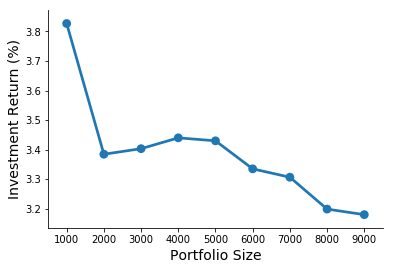

In [23]:
## Test the best-performing data-driven strategy on different portfolio sizes
##Please note we didn't run 100 rounds this time becasue the default-based strategy takes about 30 mins per dataset,
##which would have been very time-consuming
result_sensitivity = []
average_returns = []
params = {
    'criterion': ['gini'], 'max_depth': [8], 'max_features': ['log2'], 'n_estimators':[500]
}
## Vary the portfolio size from 1,000 to 10,000
reg_rf_separate = fit_regression(RandomForestRegressor(n_jobs=-1), data_dic_reg,
                       cv_parameters = {}, separate = True, model_name = "RF separated", random_state=default_seed, 
                       output_to_file = False, print_to_screen=False)
classifier_dataset, a, b = fit_classification(RandomForestClassifier(n_jobs=-1), data_dic_reg,
                          cv_parameters = params,
                          model_name = 'RF Best Model',
                          random_state = default_seed,
                          output_to_file = False,
                          print_to_screen = False)
for num_loans in list(range(1000,10000,1000)):
    #### Make sure to do the best strategy from the 4 above
    average_returns = []    
    reg_0 = test_investments(data_dic_reg, classifier=classifier_dataset, regressor=reg_rf_separate, strategy = 'Default-return-based', 
                                  num_loans = num_loans, output_to_file = False) 
    average_returns.append(reg_0['ret_PESS']['average return'])
    result_sensitivity.append(np.array(average_returns).mean())
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(1000,10000,1000))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()